In [12]:
import numpy as np # v. 1.22.1
import matplotlib.pyplot as plt # v. 3.7.5
import os
import pandas as pd # v. 1.5.3
import seaborn as sns # v. 0.12.2
import pykrev as pk # v. 1.2.4
import datetime
import re
import ms_functions_and_defs as msf
from scipy.stats import gaussian_kde

In [13]:
ms_dir = '../../MS_data'

intensity_ordination_table_path = 'CSV_files/processed_csv_data_dir/overall_intensity_ordination_table.csv'
mz_ordination_table_path = 'CSV_files/processed_csv_data_dir/overall_mz_ordination_table.csv'

mz_limits = [200,800]

In [14]:
# Change directory to the ms_dir
try: os.chdir(ms_dir)
except FileNotFoundError: pass
plots_dir = 'plots'
if not os.path.exists(plots_dir): os.mkdir(plots_dir)

cmap = 'summer'

In [15]:
df_intensity = pd.read_csv(intensity_ordination_table_path,index_col=0)
df_intensity = df_intensity[df_intensity['replicate_y/n']==0].drop(['replicate_y/n'],axis=1)

df_mz = pd.read_csv(mz_ordination_table_path,index_col=0)
df_mz = df_mz[df_mz['replicate_y/n']==0].drop(['replicate_y/n'],axis=1)

In [16]:
assert np.all(df_mz.index == df_intensity.index), 'The samples (indices) in df_mz and df_intensity must be the same'
sample_names = df_mz.index

assert np.all(df_mz.columns == df_intensity.columns), 'The compounds (columns headers) in df_mz and df_intensity must be the same'
molecformulae_strs = df_mz.columns

In [17]:
# filter the values based on the m/z restraints given before
if mz_limits != []:
    avg_mz = np.nanmean(df_mz, axis=0)
    # mz_filter = np.where((avg_mz>np.min(mz_limits))&(avg_mz<np.max(mz_limits)))
    filtered_formulae = molecformulae_strs[np.where((avg_mz>np.min(mz_limits))&(avg_mz<np.max(mz_limits)))]
    df_mz = df_mz[filtered_formulae]
    df_intensity = df_intensity[filtered_formulae]

In [18]:
info_dicts = []
for f in molecformulae_strs:
    info_dicts.append(msf.MolecFormulaDict(f))

In [19]:
# Fill out the missing elements in those compound that don't have them for later ease
info_dicts = np.array(info_dicts)
all_elements = []

for d in info_dicts:
    for k in d.keys():
        if k not in all_elements: all_elements.append(k)

for i in range(len(info_dicts)):
    for e in all_elements:
        if e not in info_dicts[i].keys():
            info_dicts[i][e] = 0

In [20]:
# make dataframe

for i in range(len(info_dicts)):
    if i == 0:
        info_df = pd.DataFrame(info_dicts[i], index=[molecformulae_strs[i]])
    else:
        info_df = pd.concat([info_df, pd.DataFrame(info_dicts[i], index=[molecformulae_strs[i]])],axis=0)

# info_df

In [21]:
for e in all_elements:
    if e != 'C':
        info_df[f'{e}/C'] = info_df[e] / info_df['C']
        info_df[f'{e}/C'] = info_df[e] / info_df['C']
        info_df[f'{e}/C'] = info_df[e] / info_df['C']

info_df['AI'] = msf.AI(info_df['C'],info_df['H'],info_df['O'])

kmass_list = []
kmd_list = []
z_list = []
for i in range(len(info_dicts)):
    kmass, kmd, z = msf.kendrick_analysis(info_dicts[i])
    kmass_list.append(kmass)
    kmd_list.append(kmd)
    z_list.append(z)

info_df['Kendrick_mass'] = kmass_list
info_df['KMD'] = kmd_list
info_df['z*'] = z_list
# info_df

c:\Users\s2017658\OneDrive - University of Edinburgh\Y5\Y5_Code\ms_processing\ms_functions_and_defs.py:351: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


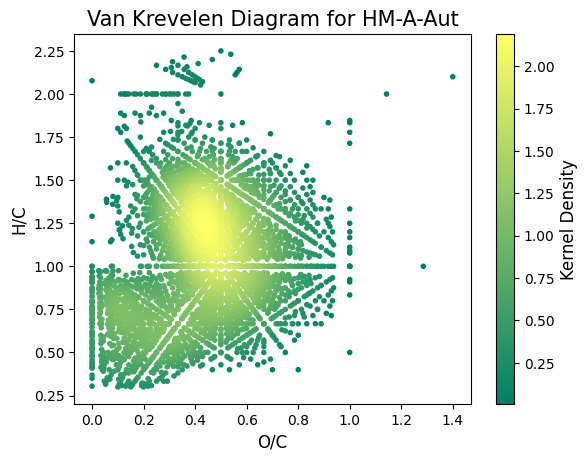

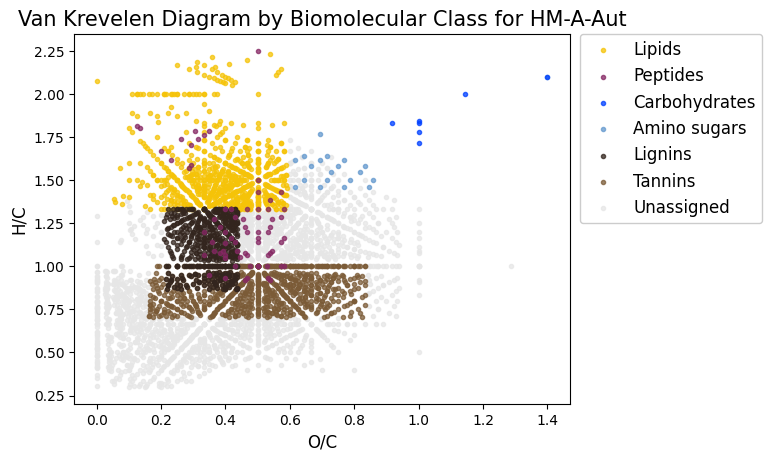

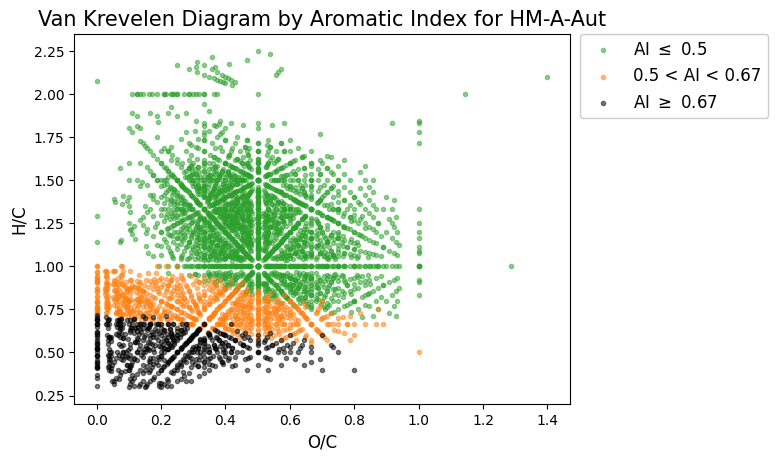

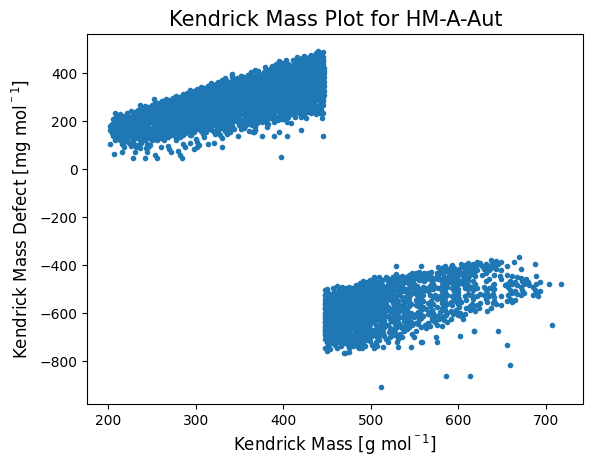

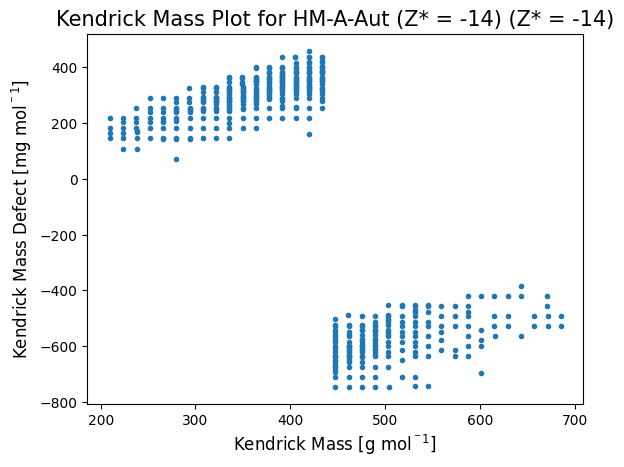

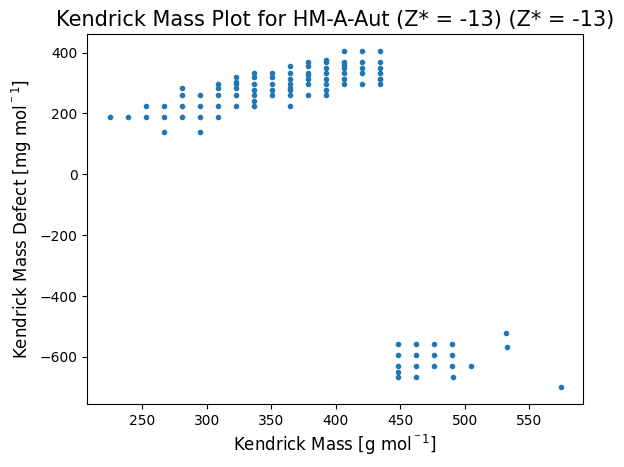

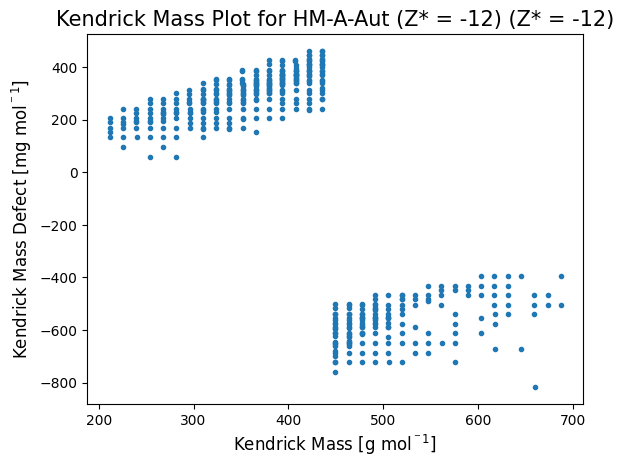

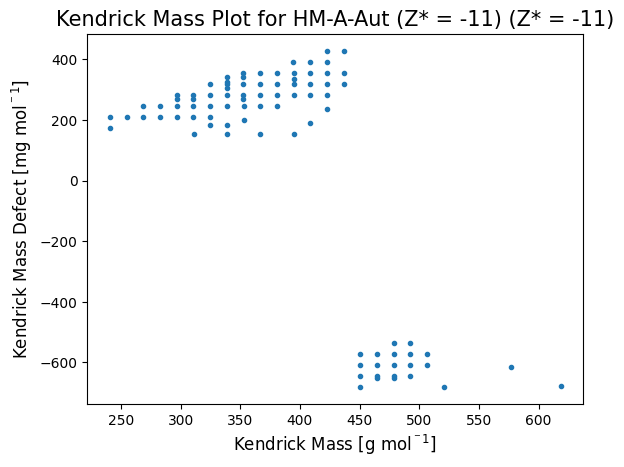

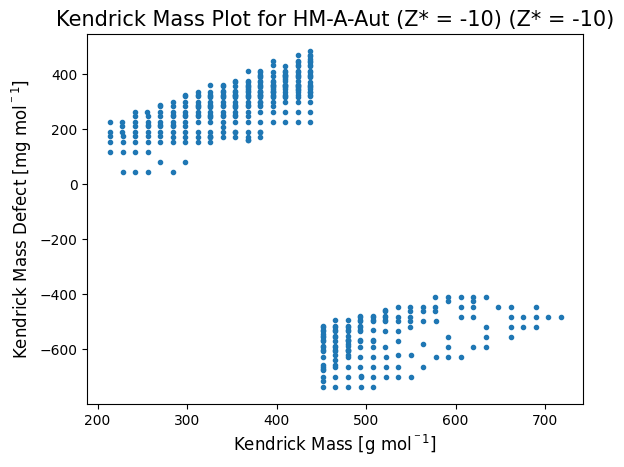

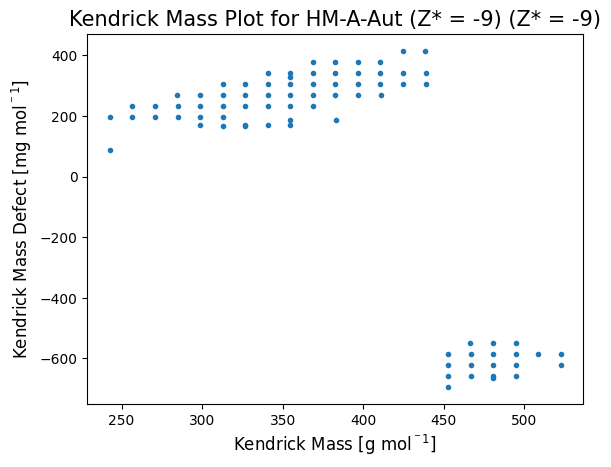

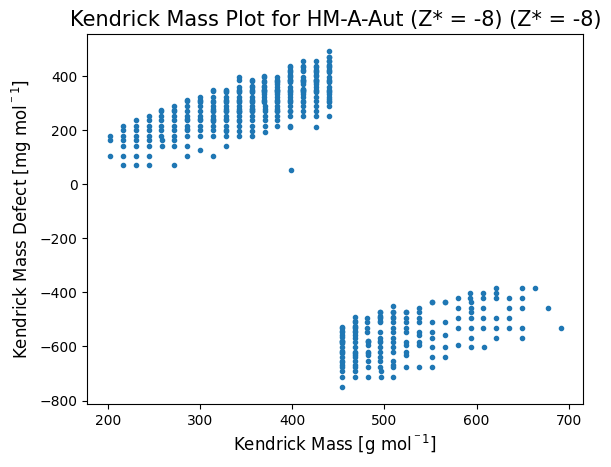

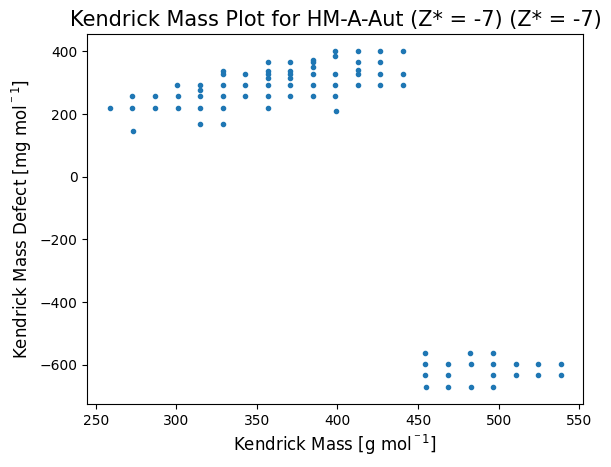

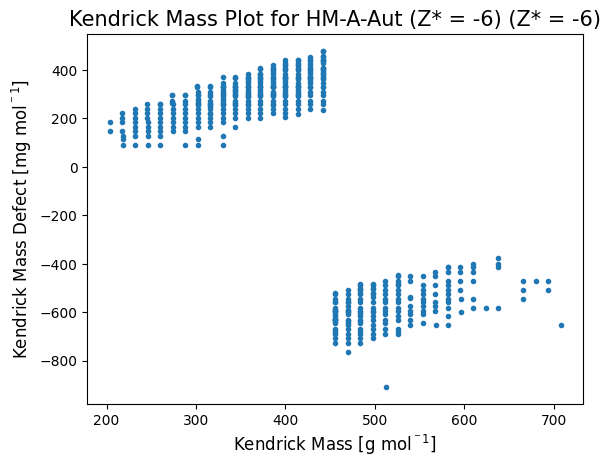

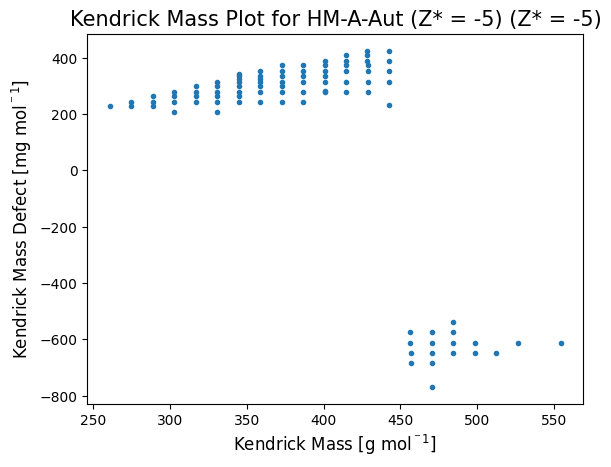

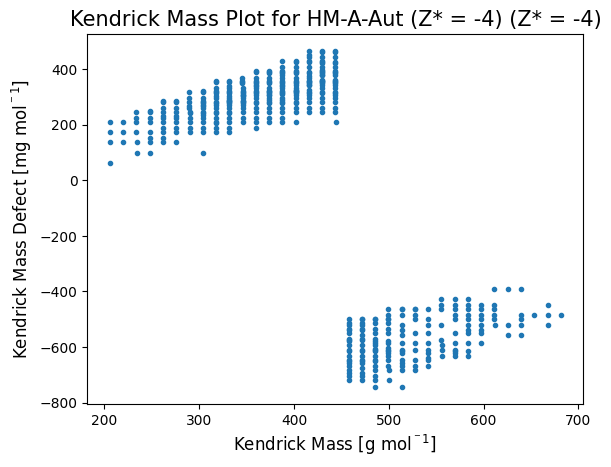

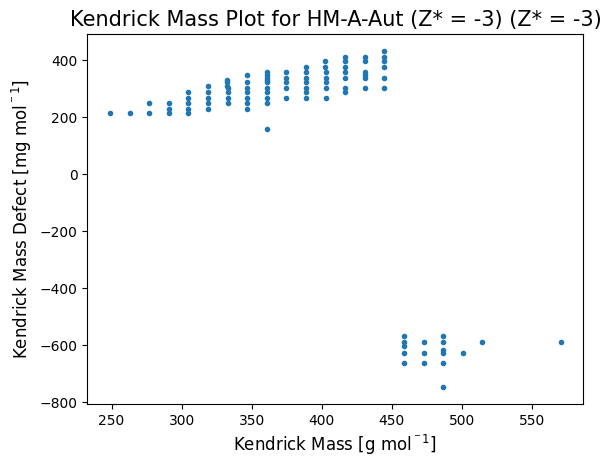

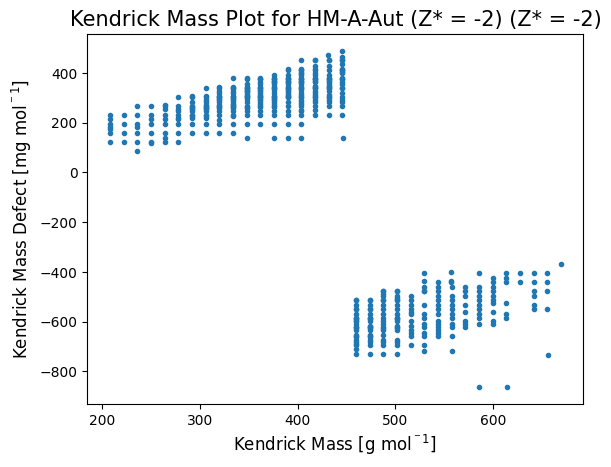

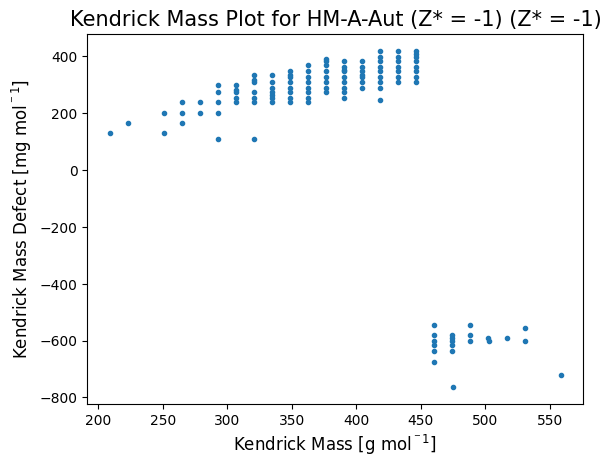

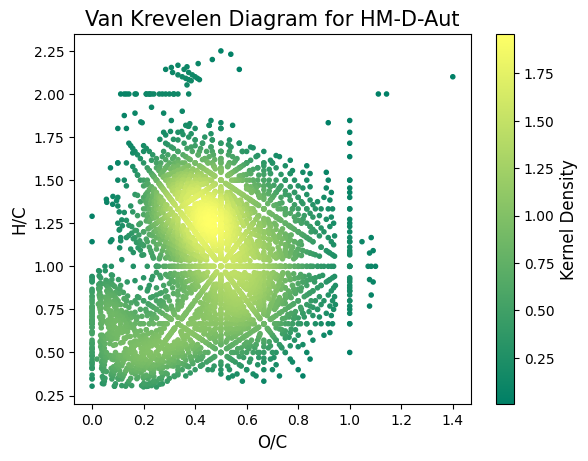

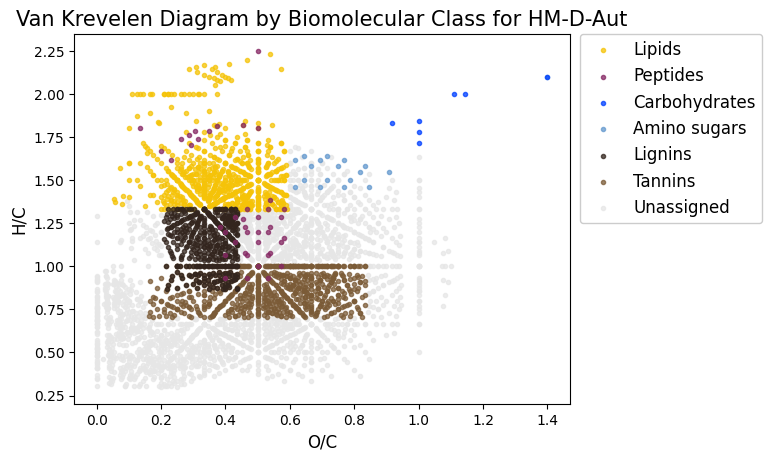

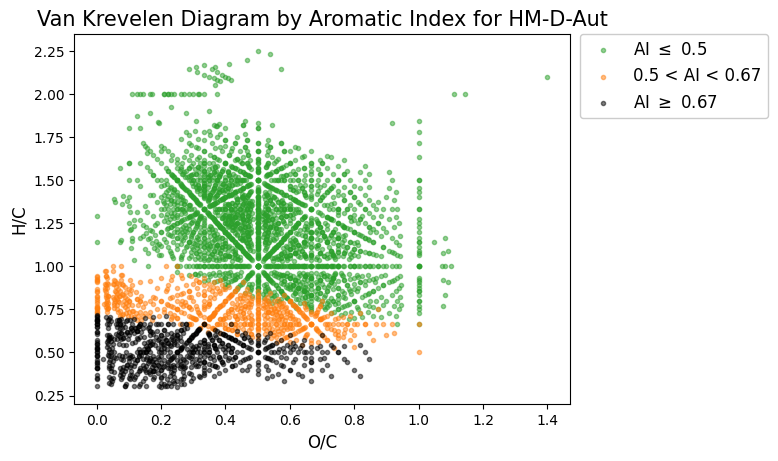

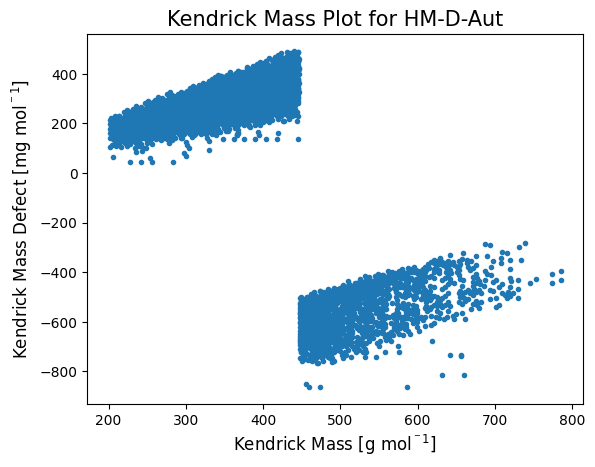

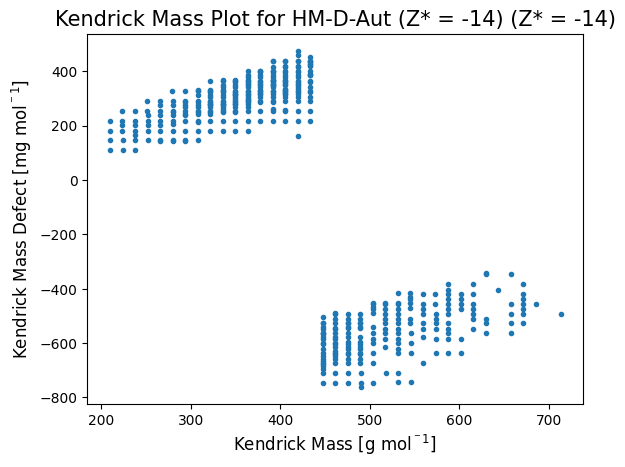

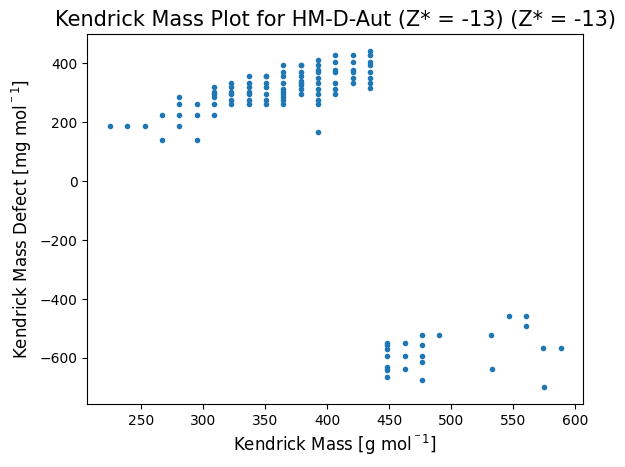

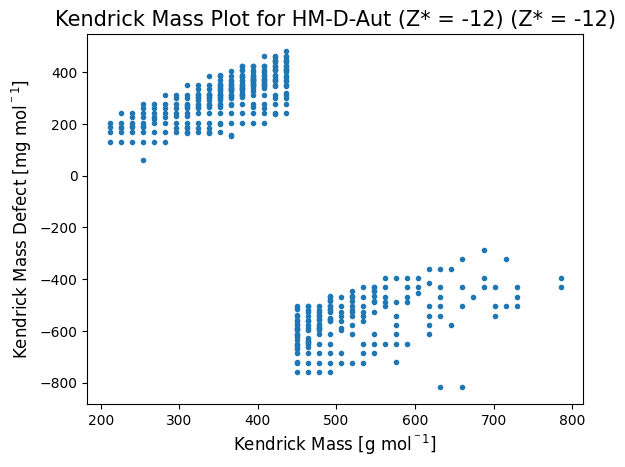

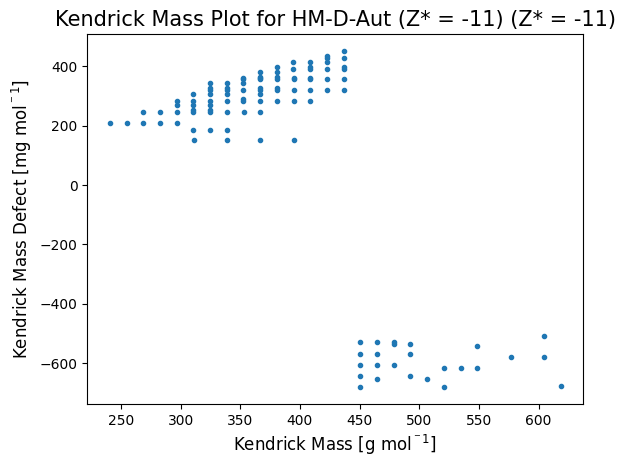

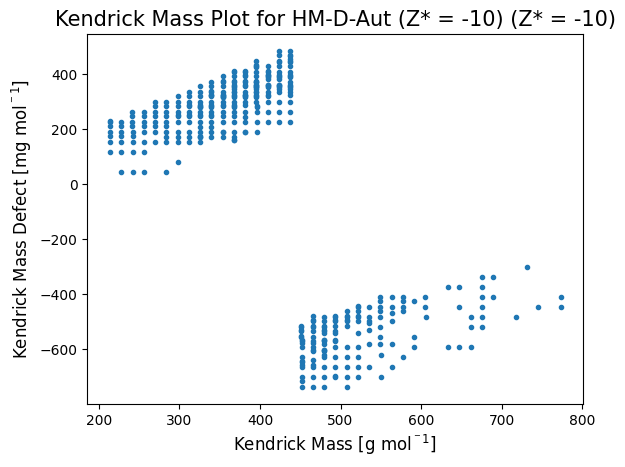

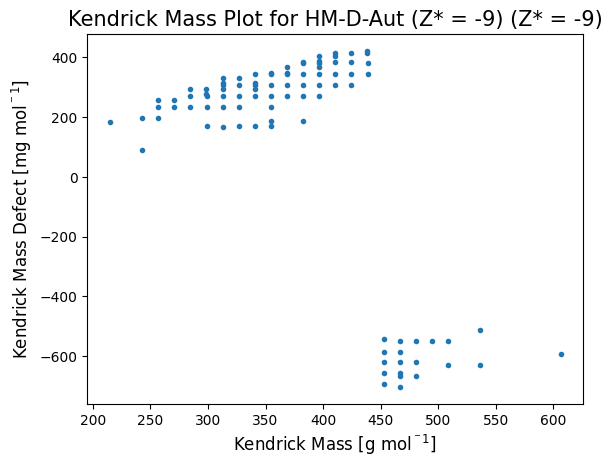

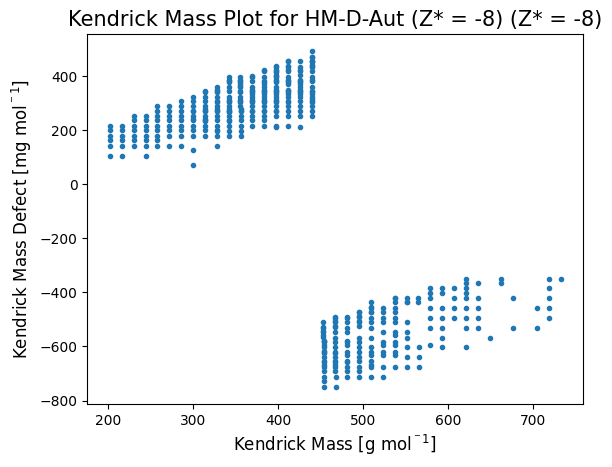

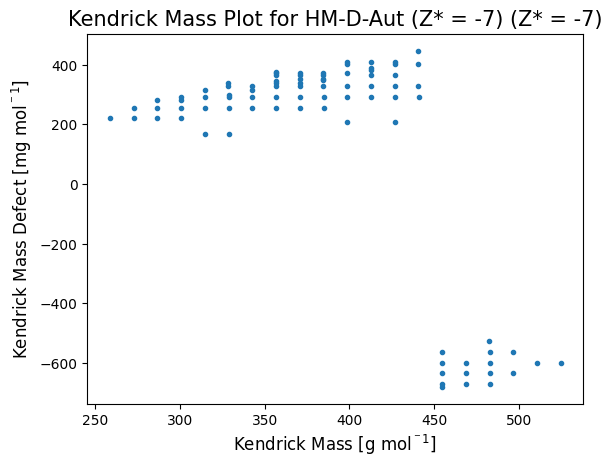

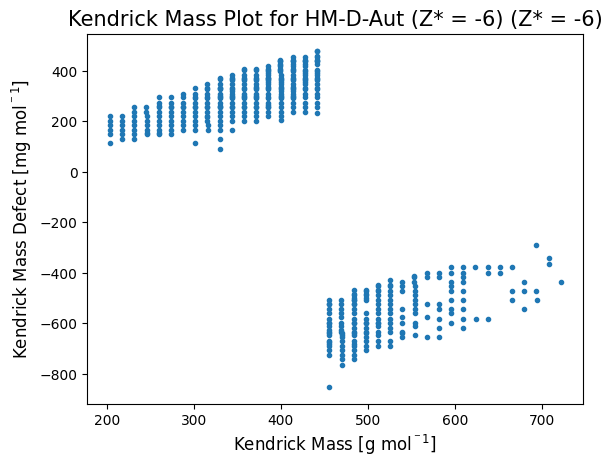

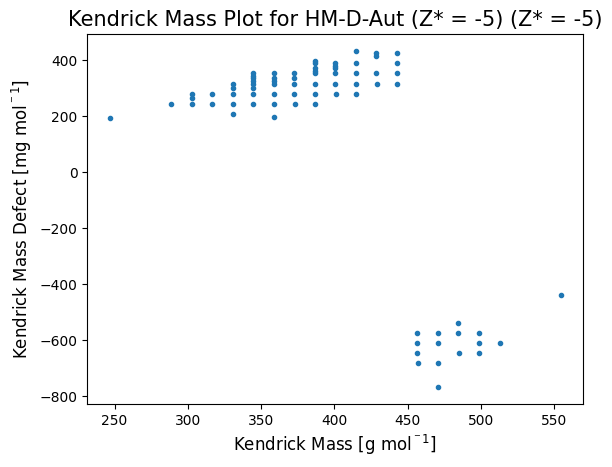

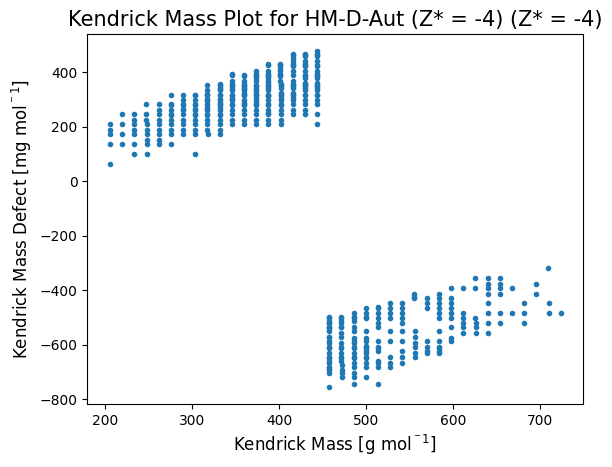

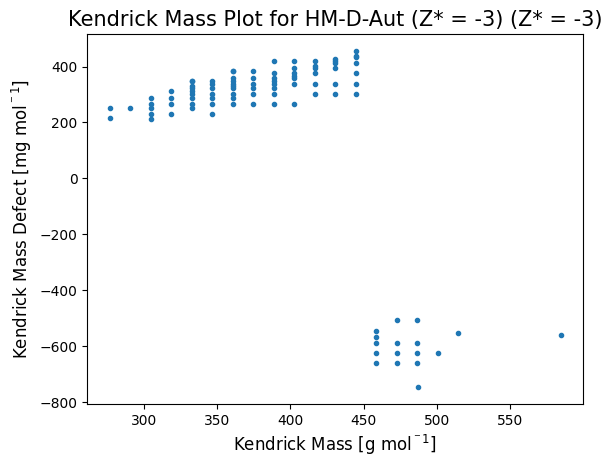

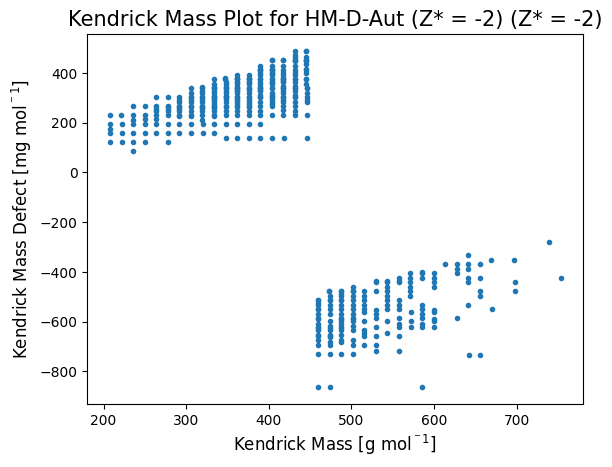

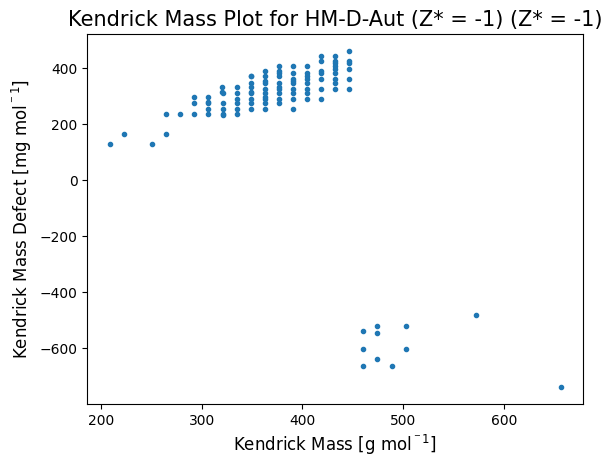

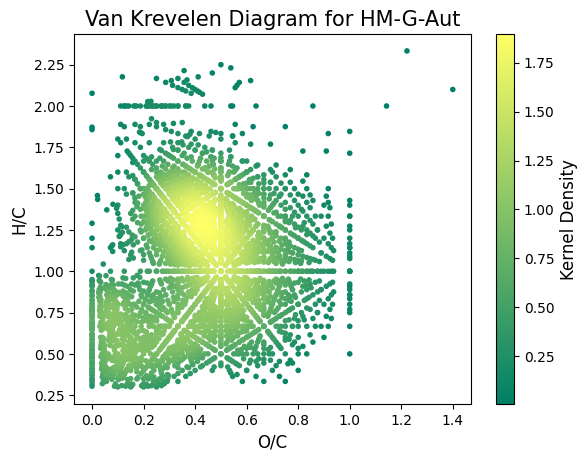

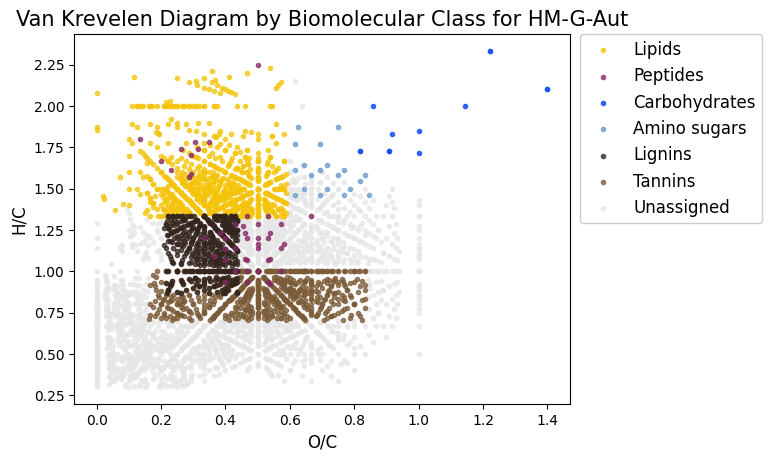

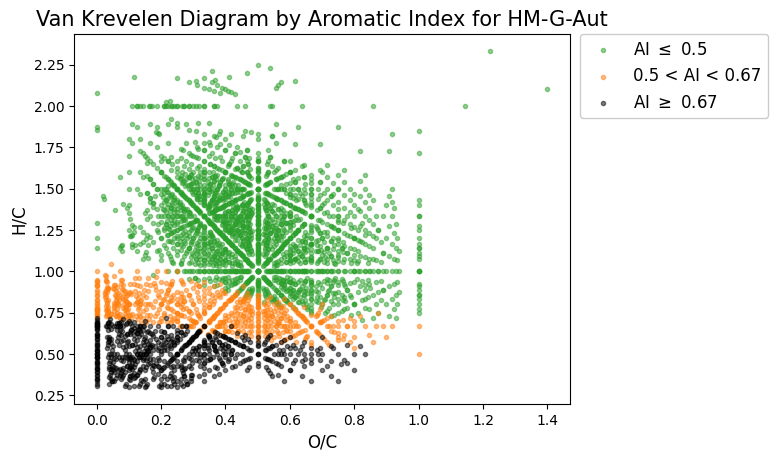

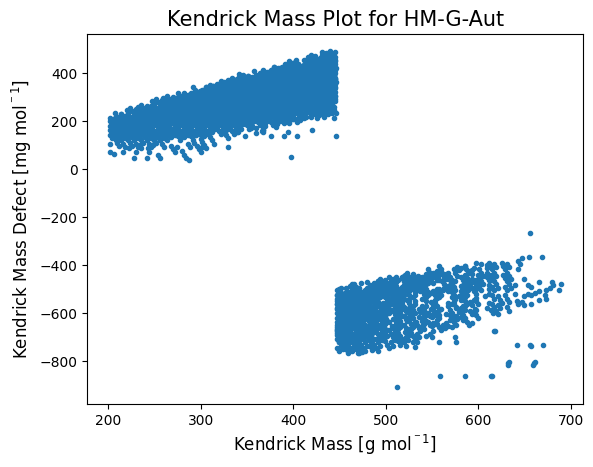

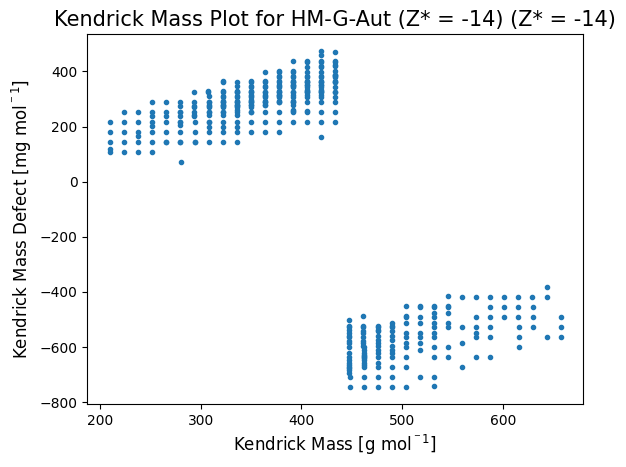

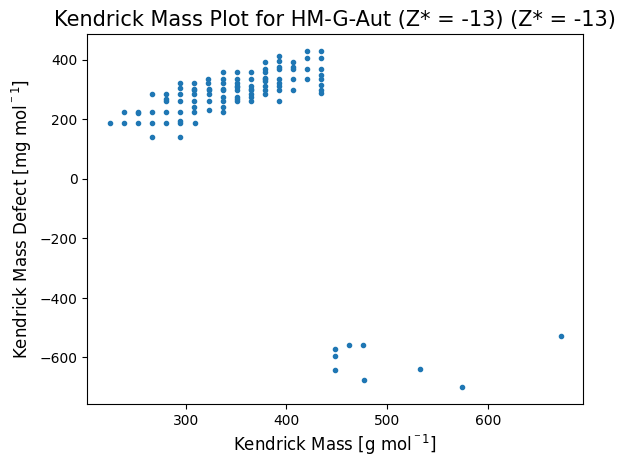

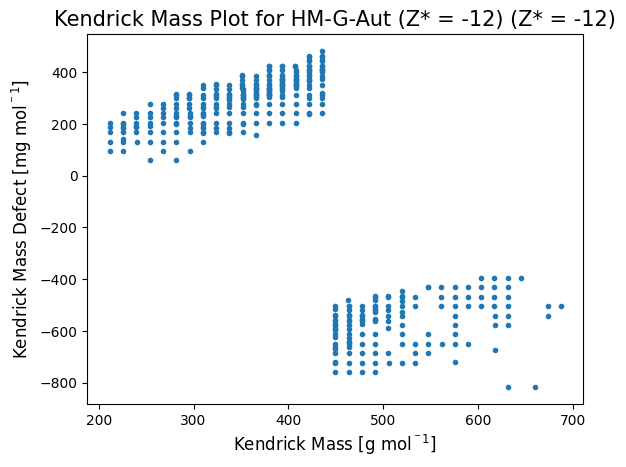

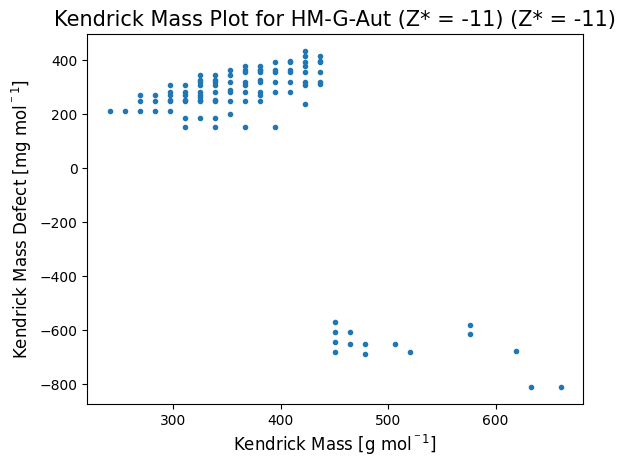

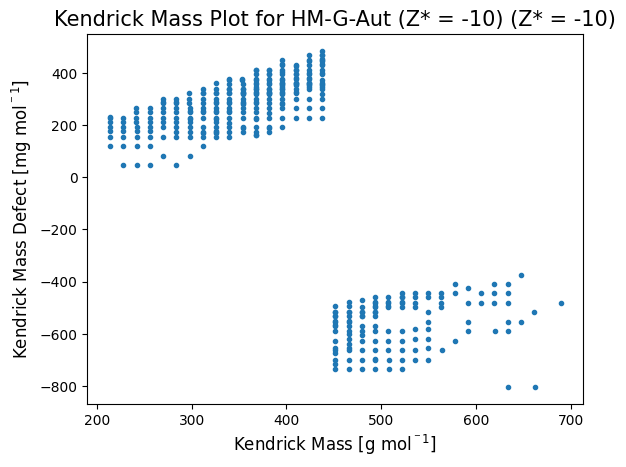

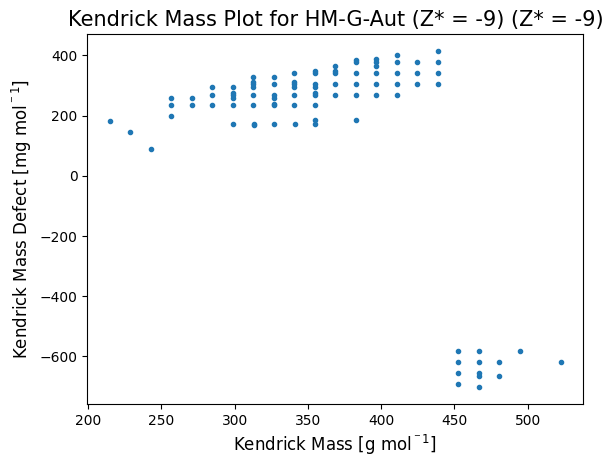

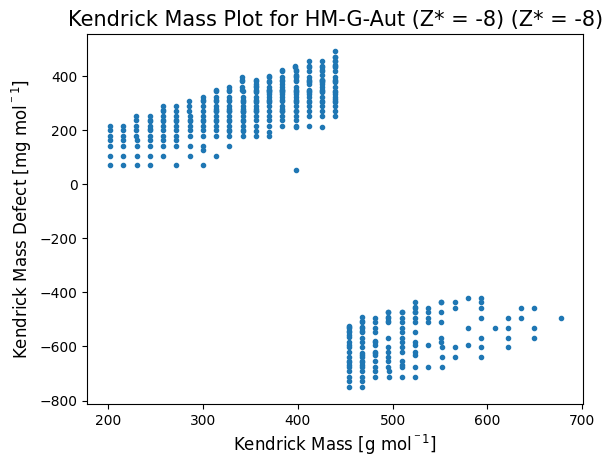

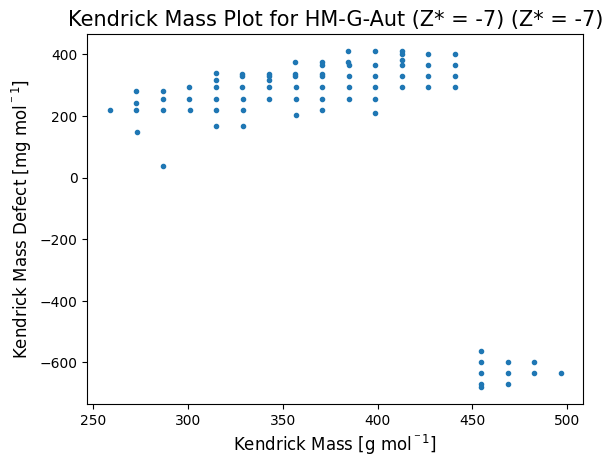

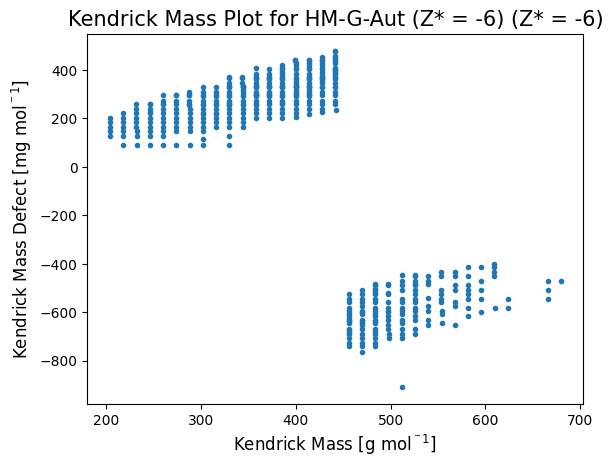

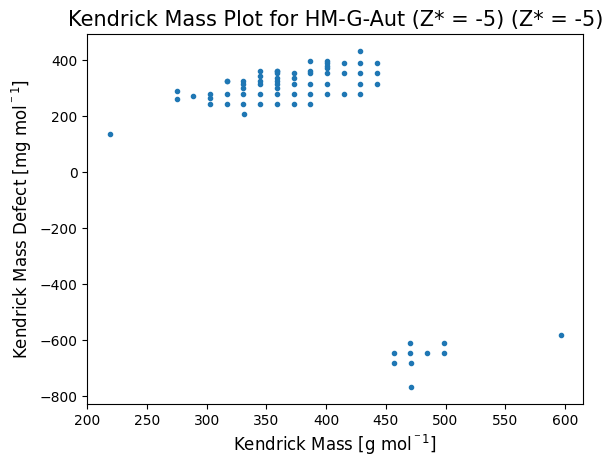

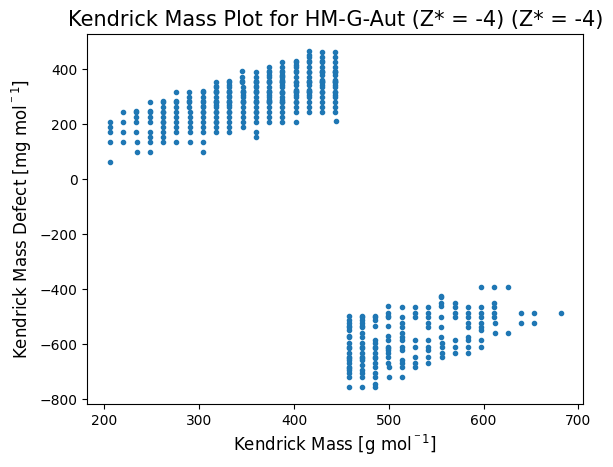

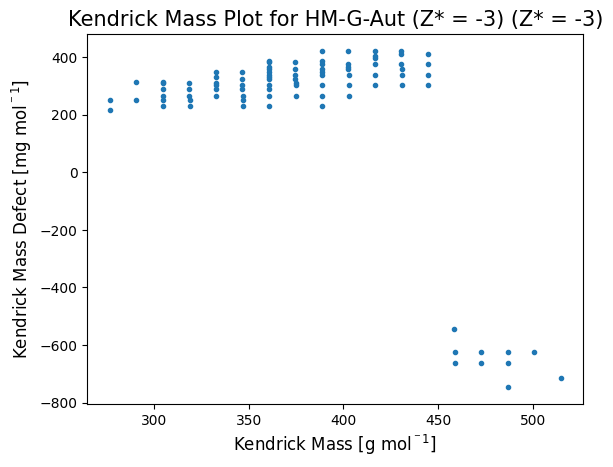

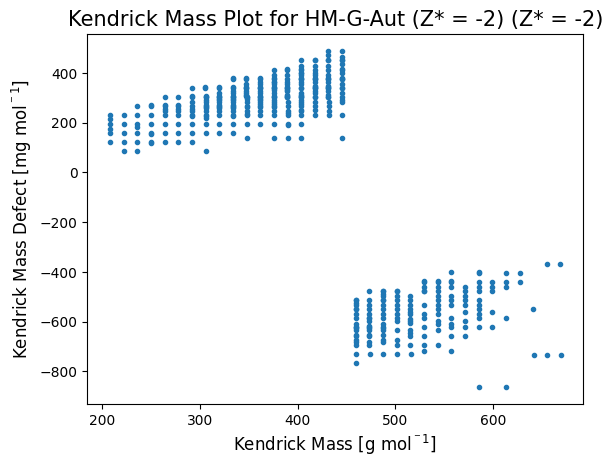

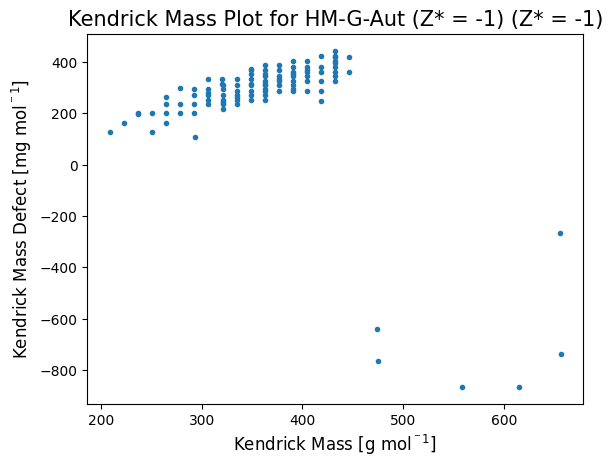

In [22]:
for name in sample_names:
    # only select the molecules in the dataframe that are present in that sample
    # molecules_present = df_mz.loc[name].copy().dropna().index

    selected_df = info_df.copy().loc[df_mz.loc[name].copy().dropna().index]

    # create the directories needed unless already there
    sample_dir = f'{plots_dir}/{name}'
    sample_kendrick_dir = f'{sample_dir}/kendrick_plots'
    if not os.path.exists(sample_dir): os.mkdir(sample_dir)
    if not os.path.exists(sample_kendrick_dir): os.mkdir(sample_kendrick_dir)

    # plot the figures and save them
    density_savepath = f"{sample_dir}/{name}_vkd_density.png"
    msf.density_vk_diagram(selected_df,cmap=cmap, title=f'Van Krevelen Diagram for {name}',save_path=density_savepath)

    molecclass_savepath = f"{sample_dir}/{name}_vkd_molecclass.png"
    msf.vk_molecclass(selected_df,alpha=0.75, title=f'Van Krevelen Diagram by Biomolecular Class for {name}',save_path=molecclass_savepath)

    ai_savepath = f"{sample_dir}/{name}_vkd_ai.png"
    msf.vk_ai(selected_df,selected_df['AI'], title=f'Van Krevelen Diagram by Aromatic Index for {name}',save_path=ai_savepath)
    
    kendrick_savepath = f"{sample_dir}/{name}_kendrick_plot.png"
    msf.kendrick_plot(selected_df['Kendrick_mass'].to_numpy(),selected_df['KMD'].to_numpy(),title=f'Kendrick Mass Plot for {name}',save_path=kendrick_savepath)

    z_unique = np.unique(selected_df['z*'])
    for z in z_unique:
        kendrick_z_savepath = f"{sample_kendrick_dir}/{name}_kendrick_plot_z={int(z)}.png"
        msf.kendrick_plot(selected_df['Kendrick_mass'].to_numpy(),selected_df['KMD'].to_numpy(),selected_df['z*'].to_numpy(),z,title=f'Kendrick Mass Plot for {name} (Z* = {z})',save_path=kendrick_z_savepath)